In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale

from library.sb_utils import save_file

In [2]:
df = pd.read_csv('../data/processed/full_data_cleaned.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33819106 entries, 0 to 33819105
Data columns (total 15 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   order_id                int64  
 1   user_id                 int64  
 2   order_by_user_sequence  int64  
 3   order_dow               int64  
 4   order_hour_of_day       int64  
 5   days_since_prior_order  float64
 6   product_id              int64  
 7   add_to_cart_sequence    int64  
 8   reordered               int64  
 9   product_name            object 
 10  aisle_name              object 
 11  dept_name               object 
 12  aisle_id                int64  
 13  department_id           int64  
 14  eval_set                object 
dtypes: float64(1), int64(10), object(4)
memory usage: 3.8+ GB


In [3]:
# What portion of users have reordered items?

reorders = df[df['reordered']==1]
users_w_reorders = reorders['user_id'].unique()
portion_users_reorder = len(users_w_reorders) / len(df['user_id'].unique())
portion_users_reorder

0.9907860471657396

In [4]:
# What portion of items in any carts are reorders?

reorder_rate = len(reorders) / len(df)
reorder_rate

0.5900617242809434

In [5]:
# Which products are reordered most?

product_order_quantity = df.groupby('product_name')['product_name'].size()
product_order_quantity

product_name
#2 Coffee Filters                                                  799
#2 Cone White Coffee Filters                                        14
#2 Mechanical Pencils                                                9
#4 Natural Brown Coffee Filters                                    247
& Go! Hazelnut Spread + Pretzel Sticks                             174
                                                                  ... 
with Xylitol Unwrapped Original Flavor 50 Sticks Sugar Free Gum     41
with Xylitol Unwrapped Spearmint 50 Sticks Sugar Free Gum           57
with Xylitol Watermelon Twist 18 Sticks Sugar Free Gum              74
with a Splash of Mango Coconut Water                                27
with a Splash of Pineapple Coconut Water                            57
Name: product_name, Length: 49685, dtype: int64

In [6]:
product_reorder_quantity = reorders.groupby('product_name')['product_name'].size()
product_reorder_quantity

product_name
#2 Coffee Filters                                                  265
#2 Cone White Coffee Filters                                         3
#4 Natural Brown Coffee Filters                                     90
& Go! Hazelnut Spread + Pretzel Sticks                              93
(70% Juice!) Mountain Raspberry Juice Squeeze                       16
                                                                  ... 
with Xylitol Unwrapped Original Flavor 50 Sticks Sugar Free Gum     17
with Xylitol Unwrapped Spearmint 50 Sticks Sugar Free Gum           20
with Xylitol Watermelon Twist 18 Sticks Sugar Free Gum              34
with a Splash of Mango Coconut Water                                 7
with a Splash of Pineapple Coconut Water                            26
Name: product_name, Length: 45603, dtype: int64

In [7]:
product_reorder_rate = product_reorder_quantity / product_order_quantity
product_reorder_rate.sort_values(ascending=False)

product_name
Raw Veggie Wrappers                                           0.942029
Serenity Ultimate Extrema Overnight Pads                      0.933333
Orange Energy Shots                                           0.923077
Chocolate Love Bar                                            0.921569
Soy Powder Infant Formula                                     0.914286
                                                                ...   
Zipper Quart Size Freezer Bags                                     NaN
Ziti Rigate Penne                                                  NaN
Zyflamend Whole Body Liquid Vcaps                                  NaN
flings! Laundry Detergent Pacs, Original, 57 Count Laundry         NaN
flings! Original Laundry Detergent Pacs                            NaN
Name: product_name, Length: 49685, dtype: float64

In [8]:
# Which aisles & departments get reordered from most?

aisle_order_quantity = df.groupby('aisle_name')['aisle_name'].size()
aisle_reorder_quantity = reorders.groupby('aisle_name')['aisle_name'].size()
aisle_reorder_rate = aisle_reorder_quantity / aisle_order_quantity

dept_order_quantity = df.groupby('dept_name')['dept_name'].size()
dept_reorder_quantity = reorders.groupby('dept_name')['dept_name'].size()
dept_reorder_rate = dept_reorder_quantity / dept_order_quantity

aisle_reorder_rate.sort_values(ascending=False)

aisle_name
milk                             0.781812
water seltzer sparkling water    0.729930
fresh fruits                     0.718823
eggs                             0.706359
soy lactosefree                  0.692361
                                   ...   
beauty                           0.212858
first aid                        0.195864
kitchen supplies                 0.194802
baking supplies decor            0.167595
spices seasonings                0.152933
Name: aisle_name, Length: 134, dtype: float64

In [9]:
dept_reorder_rate.sort_values(ascending=False)

dept_name
dairy eggs         0.670161
beverages          0.653651
produce            0.650521
bakery             0.628381
deli               0.608130
pets               0.602557
babies             0.577680
bulk               0.577090
snacks             0.574464
alcohol            0.571221
meat seafood       0.568625
breakfast          0.561351
frozen             0.542634
dry goods pasta    0.462220
canned goods       0.458639
other              0.407052
household          0.403339
missing            0.394323
international      0.369682
pantry             0.347400
personal care      0.321863
Name: dept_name, dtype: float64

In [10]:
# I want to be able to easily sort by specific user+product combination

df['user_item'] = df['user_id'].astype(str) + ', ' + df['product_id'].astype(str)
reorders = df[df['reordered']==1]
reorders.head()

,order_id,user_id,order_by_user_sequence,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_sequence,reordered,product_name,aisle_name,dept_name,aisle_id,department_id,eval_set,user_item
6,2398795,1,2,3,7,15.0,196,1,1,Soda,soft drinks,beverages,77,7,prior,"1, 196"
8,2398795,1,2,3,7,15.0,26088,5,1,Aged White Cheddar Popcorn,popcorn jerky,snacks,23,19,prior,"1, 26088"
10,2398795,1,2,3,7,15.0,12427,3,1,Original Beef Jerky,popcorn jerky,snacks,23,19,prior,"1, 12427"
11,473747,1,3,3,12,21.0,196,1,1,Soda,soft drinks,beverages,77,7,prior,"1, 196"
13,473747,1,3,3,12,21.0,10258,3,1,Pistachios,nuts seeds dried fruit,snacks,117,19,prior,"1, 10258"


In [11]:
len(df['user_item'].unique())

13863746

In [12]:
# How often are items reordered?

reordered_order_2 = reorders[reorders['order_by_user_sequence']==2]

portion_reordered_immediately = len(reordered_order_2) / len(df[df['order_by_user_sequence']==1])
portion_reordered_immediately

0.26846330341451774

In [13]:
reordered_order_3 = reorders[reorders['order_by_user_sequence']==3]
print(len(reordered_order_2), len(reordered_order_3))

557885 792161


In [14]:
reordered_2_and_3 = reordered_order_2.merge(reordered_order_3, on='user_item')
len(reordered_2_and_3)

274487

In [15]:
portion_reordered_2_and_3 = len(reordered_2_and_3) / len(df[df['order_by_user_sequence']==1])
portion_reordered_2_and_3

0.13208759289878869

In [16]:
# What portion of items that were reordered in order 2 also got reordered in order 3?

portion_reordered_2_and_3 / portion_reordered_immediately

0.4920135870295849

In [17]:
# About a quarter of items that were ordered in any given user's 1st order got reordered in their 2nd
# Of items that got reordered immediately, about half were reordered again in their 3rd order. 
# I'd like to do more to analyze reorder rates throughout the order sequence.

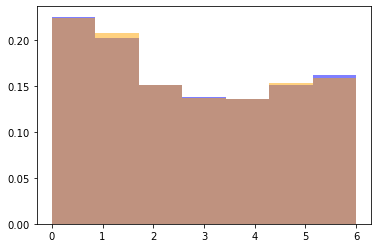

In [18]:
# What is the pattern of reorders by weekday, time, and days since prior order?

plt.hist(df['order_dow'], color='blue', density=True, alpha=0.5, bins=7)
plt.hist(reorders['order_dow'], color='orange', density=True, alpha=0.5, bins=7);

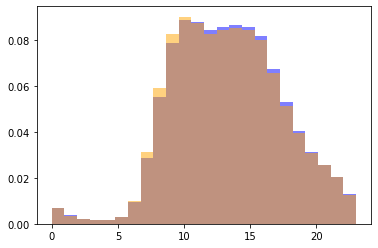

In [19]:
# reorders don't seem much more likely overall any given day of the week. 

plt.hist(df['order_hour_of_day'], color='blue', density=True, alpha=0.5, bins=24)
plt.hist(reorders['order_hour_of_day'], color='orange', density=True, alpha=0.5, bins=24);

In [20]:
# I have no idea if this is a meaningful difference because it looks quite small
# But there could be something to explore with regards to reorders being more likely from 7-10am
# Are there perhaps particular items that are popular to buy in the morning? 

df['days_since_prior_order'].max()

30.0

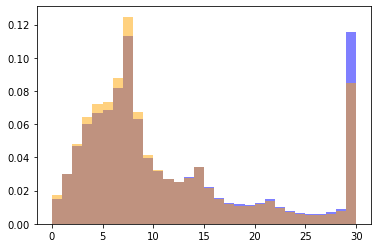

In [21]:
plt.hist(df['days_since_prior_order'], color='blue', density=True, alpha=0.5, bins=30)
plt.hist(reorders['days_since_prior_order'], color='orange', density=True, alpha=0.5, bins=30);

In [22]:
# It seems like more reorders happen when there have been under 10 days since the last order.
# I wonder if "30" here actually means "30 plus?" It's a weirdly big group. 
# At any rate, reorders seem less likely when there's a longer time between orders. 
# Could this be because more frequent shoppers get more of their staples via instacart? 

In [23]:
# Does an added to cart sequence hist say anything?
df['add_to_cart_sequence'].max()

145

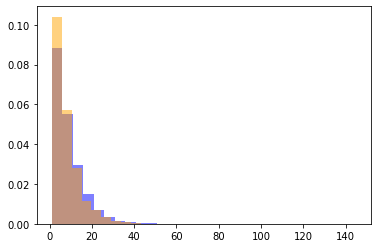

In [24]:
plt.hist(df['add_to_cart_sequence'], color='blue', density=True, alpha=0.5, bins=29)
plt.hist(reorders['add_to_cart_sequence'], color='orange', density=True, alpha=0.5, bins=29);

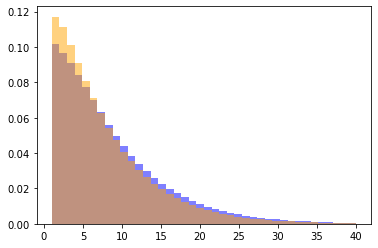

In [25]:
earlier_items_df = df[df['add_to_cart_sequence']<=40]
earlier_items_reorders = reorders[reorders['add_to_cart_sequence']<=40]

plt.hist(earlier_items_df['add_to_cart_sequence'], color='blue', density=True, alpha=0.5, bins=40)
plt.hist(earlier_items_reorders['add_to_cart_sequence'], color='orange', density=True, alpha=0.5, bins=40);

In [26]:
# Items that are added to the cart earlier (up to item 6) are more often reorders. 
# Or, to put it more accurately, I imagine, reorders are added to the cart earlier. Basics people know they want. 
# Or maybe smaller orders are more likely to consist of reorders?

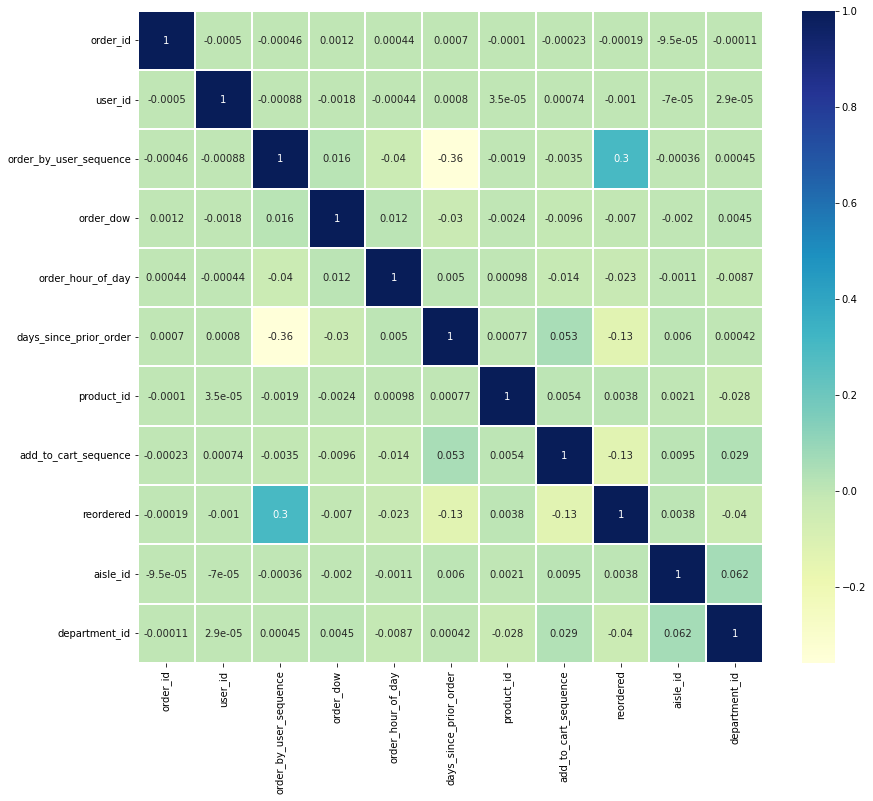

In [27]:
# Look at a correlation coefficient heatmap
plt.figure(figsize=(14,12))
sns.heatmap(df.corr(), linewidths=.1, cmap="YlGnBu", annot=True)
plt.yticks(rotation=0);

In [28]:
# Next up: cluster products

In [29]:
# Review instructions for EDA in the curriculum to make sure I'm not missing important aspects. 